In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchinfo import summary
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math
#from tqdm.notebook import tqdm

from train_test import train, test

# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## MNIST Dataset

In [2]:
VAL_SIZE = 0.1
BATCH_SIZE = 64

# download the training and testing datasets
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./root',
                                          train=False,
                                          transform=transforms.ToTensor(),
                                          download=True)

# split the training set into train and validation sets
train_indices, val_indices, _, _ = train_test_split(range(len(train_dataset)),
                                                    train_dataset.targets,
                                                    stratify=train_dataset.targets,
                                                    test_size=VAL_SIZE)

train_split = Subset(train_dataset, train_indices)
val_split = Subset(train_dataset, val_indices)

# now create the batches of the train, val, test sets
train_loader = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_split, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

844
94
157


torch.Size([28, 28])


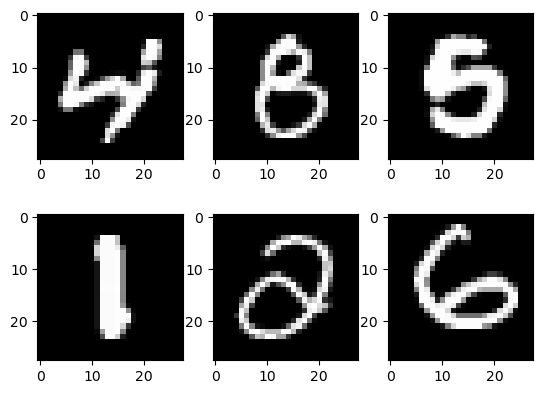

In [3]:
# show some samples from test set

samples = iter(test_loader)
sample_data, sample_targets = next(samples)
print((sample_data[0][0]).size())

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(sample_data[i][0], cmap='gray')
plt.show()

## Model

We build these main blocks:
- DenseBlocks:
    - BottleneckBlock: if we set bottleneck=True. it is used to reduce the computation complexity, here we use conv_1x1 to reduce the number of channels before the conv_3x3. Then concatenate with the previous BottleneckBlock output
    - SingleBlock: if we set bottleneck=False. we use the standard dense layers which concatenate with the previous SingleBlock
- TransitionBlock: where we apply the reduction step before using the dense blocks

### DenseNet Representation
<div>
<center><img src="images/denseNet/denseNet.png" width="600" center=/></center>
</div>

### Dense Block
<div>
<center><img src="images/denseNet/dense_block.png" width="600" center=/></center>
</div>
Here we can see that in each step we make a convolution with out_channles = growth_rate and then concat the previous channels

In [4]:
# BottleneckBlock

class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(BottleneckBlock, self).__init__()
        reduced_channels = 4 * growth_rate
        
        self.conv1_bn = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, reduced_channels, kernel_size=1, bias=False)
        
        self.conv2_bn = nn.BatchNorm2d(reduced_channels)
        self.conv2 = nn.Conv2d(reduced_channels, growth_rate, kernel_size=3, padding=1, bias=False)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(self.relu(self.conv1_bn(x)))
        out = self.conv2(self.relu(self.conv2_bn(out)))
        out = torch.cat((x, out), 1)
        return out

In [5]:
# SingleBlock

class SingleBlock(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(SingleBlock, self).__init__()

        self.conv_bn = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1, bias=False)

        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.conv(self.relu(self.conv_bn(x)))
        out = torch.cat((x, out), 1)
        
        return out

In [6]:
# TransitionBlock

class TransitionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionBlock, self).__init__()
        
        self.conv_bn = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        #self.avgpool = nn.AvgPool2d(out_channels, 2)
        self.avgpool = nn.MaxPool2d(2, 2)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.conv(self.relu(self.conv_bn(x)))
        out = self.avgpool(out)
        
        return out

In [7]:
# DenseNet

# growth_rate: how many layers are added at each dense layer step in the dense Blocks
# depth: is used to control the number of the n_dense_blocks, in my case I set it manually to a constant value
# reduction: in case we have a lot of channels at the end of each transaction step we can reduce them setting a reductio factor
# num_classes: are the number of class we want to predict
# bottlenet: True if we want to add more reduction inside the dense blocks adding a 1x1_conv

class DenseNet(nn.Module):
    def __init__(self, growth_rate, depth, reduction, num_classes, bottleneck):
        super(DenseNet, self).__init__()
        
        n_dense_blocks = 3 #(depth-4) // 3 here we can set how many dense layers to concatenate we have in each dense block
        if bottleneck:
            n_dense_blocks //= 2
            
        channels = 2 * growth_rate
        
        self.conv1 = nn.Conv2d(1, channels, kernel_size=3, padding=1, bias=False)
        self.dense1 = self._make_dense(channels, growth_rate, n_dense_blocks, bottleneck)
        channels += n_dense_blocks * growth_rate
        out_channels = int(math.floor(channels*reduction))
        self.trans1 = TransitionBlock(channels, out_channels)
        
        channels = out_channels
        self.dense2 = self._make_dense(channels, growth_rate, n_dense_blocks, bottleneck)
        channels += n_dense_blocks * growth_rate
        out_channels = int(math.floor(channels*reduction))
        self.trans2 = TransitionBlock(channels, out_channels)
        
        channels = out_channels
        self.dense3 = self._make_dense(channels, growth_rate, n_dense_blocks, bottleneck)
        channels += n_dense_blocks * growth_rate
        
        self.bn = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU()
        
        self.adaptAvgPool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(channels, num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
        
    def _make_dense(self, channels, growth_rate, n_dense_blocks, bottleneck):
        layers = []
        for i in range(int(n_dense_blocks)):
            if bottleneck:
                layers.append(BottleneckBlock(channels, growth_rate))
            else:
                layers.append(SingleBlock(channels, growth_rate))
                
            channels += growth_rate
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(self.dense1(x))
        x = self.trans2(self.dense2(x))
        x = self.dense3(x)
        x = self.relu(self.bn(x))
        x = self.adaptAvgPool(x)
        x = x.reshape(x.shape[0], -1) # flatten the out in a single vector
        x = self.fc1(x)
        
        return x

In [8]:
model = DenseNet(growth_rate=12, depth=0, reduction=0.8,
                            bottleneck=False, num_classes=10).to(device)
summary(model, input_size=(BATCH_SIZE, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
DenseNet                                 [64, 10]                  --
├─Conv2d: 1-1                            [64, 24, 28, 28]          216
├─Sequential: 1-2                        [64, 60, 28, 28]          --
│    └─SingleBlock: 2-1                  [64, 36, 28, 28]          --
│    │    └─BatchNorm2d: 3-1             [64, 24, 28, 28]          48
│    │    └─ReLU: 3-2                    [64, 24, 28, 28]          --
│    │    └─Conv2d: 3-3                  [64, 12, 28, 28]          2,592
│    └─SingleBlock: 2-2                  [64, 48, 28, 28]          --
│    │    └─BatchNorm2d: 3-4             [64, 36, 28, 28]          72
│    │    └─ReLU: 3-5                    [64, 36, 28, 28]          --
│    │    └─Conv2d: 3-6                  [64, 12, 28, 28]          3,888
│    └─SingleBlock: 2-3                  [64, 60, 28, 28]          --
│    │    └─BatchNorm2d: 3-7             [64, 48, 28, 28]          96
│    │  

## Training and Validation the Model

In [9]:
# loss and optmizer
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
EPOCHS = 5 #100

for epoch in range(EPOCHS):
    print(f"[INFO]: Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, criterion)
    print('\n')
    val_epoch_loss, val_epoch_acc = test(model, val_loader, criterion)
    
    print('\n')
    print(f"training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}%")
    print(f"validation loss: {val_epoch_loss:.3f}, validation acc: {val_epoch_acc:.3f}%")
    print('-'*50)

In [ ]:
"""
# save the trained model to disk
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, './model.pth')
""";